# EDGES STATISTICAL SIGNIFICANCE TEST


In this notebook, I will determine whether including edges in the graph structure is statistically significant. I hope it is.

First, we must generate our data:

## Generating Data

We will create and train a total of 20 models -- 10 of which with a total of 180 edges (ie 5 edegs connecting each node), 10 of which with 36 edges (no edges connecting each node, only a self-loop). For each epoch in 100 epochs, we will record the training loss. Then, we will take the average of the last 10 epochs of the list of losses for each model. We will create a list of the average epoch loss for every model to use in our t-test.

As a note, all configs will have the same hyperparameters, as determined in chem_talk_figures.

In [9]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import ml_collections

from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 
import jax.numpy as jnp
import jraph

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state

In [11]:
def create_config(seed, connected=None):
    config = ml_collections.ConfigDict()

    # Data params. 
    config.n_samples=5000
    config.input_steps=1
    config.output_delay=0 # predict 0 hours into the future
    config.output_steps=4
    config.timestep_duration=3
    config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    config.time_resolution=120
    config.init_buffer_samples=0
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=seed+65
    config.normalize=True
    config.fully_connected_edges=connected

    # Optimizer.
    config.optimizer = 'sgd'
    config.learning_rate = 0.00045346796177033903
    config.momentum = 0.8712873602503628

    # Training hyperparameters.
    # config.batch_size = 3
    config.epochs = 50
    config.log_every_epochs = 1
    config.eval_every_epochs = 1
    config.checkpoint_every_epochs = 10
    config.max_checkpts_to_keep = None # None means keep all checkpoints

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = 1
    config.activation = 'relu'
    config.dropout_rate = 0.013287043114620523
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.edge_features = (8, 8) # the last feature size will be the number of features that the graph predicts
    config.node_features = (32, 2)
    config.global_features = None
    config.share_params = False
    return config

In [12]:
num_trials = 10

In [13]:
fully_connected_configs = []
connected_configs_7 = []
connected_configs_5 = []
connected_configs_3 = []
solo_configs = []

for trial in range(num_trials):
    fully_connected_config = create_config(trial)
    connected_config_7 = create_config(trial, connected=7)
    connected_config_5 = create_config(trial, connected=5)
    connected_config_3 = create_config(trial, connected=3)
    solo_config = create_config(trial, connected=1)

    fully_connected_configs.append(fully_connected_config)
    connected_configs_7.append(connected_config_7)
    connected_configs_5.append(connected_config_5)
    connected_configs_3.append(connected_config_3)
    solo_configs.append(solo_config)

In [14]:
from utils.jraph_data import get_lorenz_graph_tuples

In [15]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [16]:
all_fully_connected_datasets = []
all_connected_7_datasets = []
all_connected_5_datasets = []
all_connected_3_datasets = []
all_solo_datasets = []

for fully_connected_config in fully_connected_configs:
    fully_connected_datasets = get_lorenz_graph_tuples(
        n_samples=fully_connected_config.n_samples,
        input_steps=fully_connected_config.input_steps,
        output_delay=fully_connected_config.output_delay,
        output_steps=fully_connected_config.output_steps,
        timestep_duration=fully_connected_config.timestep_duration,
        sample_buffer=fully_connected_config.sample_buffer,
        time_resolution=fully_connected_config.time_resolution,
        init_buffer_samples=fully_connected_config.init_buffer_samples,
        train_pct=fully_connected_config.train_pct,
        val_pct=fully_connected_config.val_pct,
        test_pct=fully_connected_config.test_pct,
        K=fully_connected_config.K,
        F=fully_connected_config.F,
        c=fully_connected_config.c,
        b=fully_connected_config.b,
        h=fully_connected_config.h,
        seed=fully_connected_config.seed,
        normalize=fully_connected_config.normalize,
        fully_connected_edges=fully_connected_config.fully_connected_edges)
    all_fully_connected_datasets.append(fully_connected_datasets)

for connected_config_7 in connected_configs_7:
    connected_7_datasets = get_lorenz_graph_tuples(
        n_samples=connected_config_7.n_samples,
        input_steps=connected_config_7.input_steps,
        output_delay=connected_config_7.output_delay,
        output_steps=connected_config_7.output_steps,
        timestep_duration=connected_config_7.timestep_duration,
        sample_buffer=connected_config_7.sample_buffer,
        time_resolution=connected_config_7.time_resolution,
        init_buffer_samples=connected_config_7.init_buffer_samples,
        train_pct=connected_config_7.train_pct,
        val_pct=connected_config_7.val_pct,
        test_pct=connected_config_7.test_pct,
        K=connected_config_7.K,
        F=connected_config_7.F,
        c=connected_config_7.c,
        b=connected_config_7.b,
        h=connected_config_7.h,
        seed=connected_config_7.seed,
        normalize=connected_config_7.normalize,
        fully_connected_edges=connected_config_7.fully_connected_edges)
    all_connected_7_datasets.append(connected_7_datasets)
    
for connected_config_5 in connected_configs_5:
    connected_5_datasets = get_lorenz_graph_tuples(
        n_samples=connected_config_5.n_samples,
        input_steps=connected_config_5.input_steps,
        output_delay=connected_config_5.output_delay,
        output_steps=connected_config_5.output_steps,
        timestep_duration=connected_config_5.timestep_duration,
        sample_buffer=connected_config_5.sample_buffer,
        time_resolution=connected_config_5.time_resolution,
        init_buffer_samples=connected_config_5.init_buffer_samples,
        train_pct=connected_config_5.train_pct,
        val_pct=connected_config_5.val_pct,
        test_pct=connected_config_5.test_pct,
        K=connected_config_5.K,
        F=connected_config_5.F,
        c=connected_config_5.c,
        b=connected_config_5.b,
        h=connected_config_5.h,
        seed=connected_config_5.seed,
        normalize=connected_config_5.normalize,
        fully_connected_edges=connected_config_5.fully_connected_edges)
    all_connected_5_datasets.append(connected_5_datasets)

for connected_config_3 in connected_configs_3:
    connected_3_datasets = get_lorenz_graph_tuples(
        n_samples=connected_config_3.n_samples,
        input_steps=connected_config_3.input_steps,
        output_delay=connected_config_3.output_delay,
        output_steps=connected_config_3.output_steps,
        timestep_duration=connected_config_3.timestep_duration,
        sample_buffer=connected_config_3.sample_buffer,
        time_resolution=connected_config_3.time_resolution,
        init_buffer_samples=connected_config_3.init_buffer_samples,
        train_pct=connected_config_3.train_pct,
        val_pct=connected_config_3.val_pct,
        test_pct=connected_config_3.test_pct,
        K=connected_config_3.K,
        F=connected_config_3.F,
        c=connected_config_3.c,
        b=connected_config_3.b,
        h=connected_config_3.h,
        seed=connected_config_3.seed,
        normalize=connected_config_3.normalize,
        fully_connected_edges=connected_config_3.fully_connected_edges)
    all_connected_3_datasets.append(connected_3_datasets)

for solo_config in solo_configs:
    solo_datasets = get_lorenz_graph_tuples(
        n_samples=solo_config.n_samples,
        input_steps=solo_config.input_steps,
        output_delay=solo_config.output_delay,
        output_steps=solo_config.output_steps,
        timestep_duration=solo_config.timestep_duration,
        sample_buffer=solo_config.sample_buffer,
        time_resolution=solo_config.time_resolution,
        init_buffer_samples=solo_config.init_buffer_samples,
        train_pct=solo_config.train_pct,
        val_pct=solo_config.val_pct,
        test_pct=solo_config.test_pct,
        K=solo_config.K,
        F=solo_config.F,
        c=solo_config.c,
        b=solo_config.b,
        h=solo_config.h,
        seed=solo_config.seed,
        normalize=solo_config.normalize,
        fully_connected_edges=solo_config.fully_connected_edges)
    all_solo_datasets.append(solo_datasets)

INFO:root:starting integration


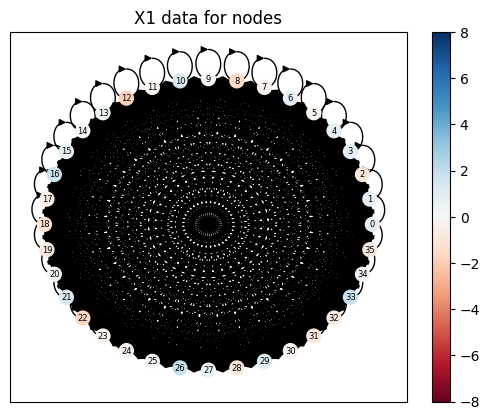

In [17]:
from utils.jraph_vis import draw_jraph_graph_structure

sample_graph = all_fully_connected_datasets[0]['train']['inputs'][0][0]
draw_jraph_graph_structure(sample_graph)


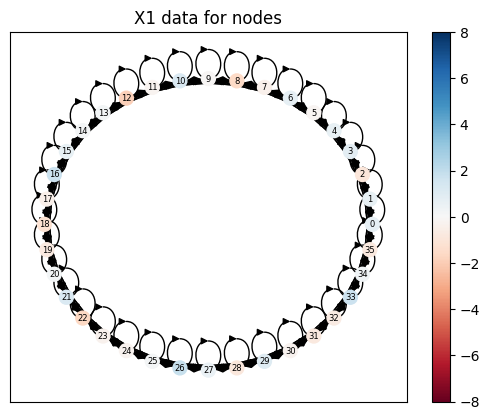

In [18]:
sample_graph = all_connected_7_datasets[0]['train']['inputs'][0][0]
draw_jraph_graph_structure(sample_graph)

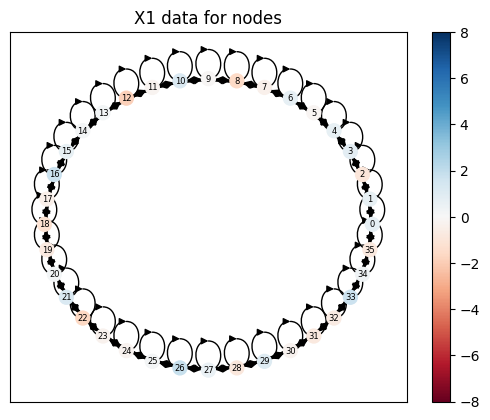

In [19]:
sample_graph = all_connected_5_datasets[0]['train']['inputs'][0][0]
draw_jraph_graph_structure(sample_graph)

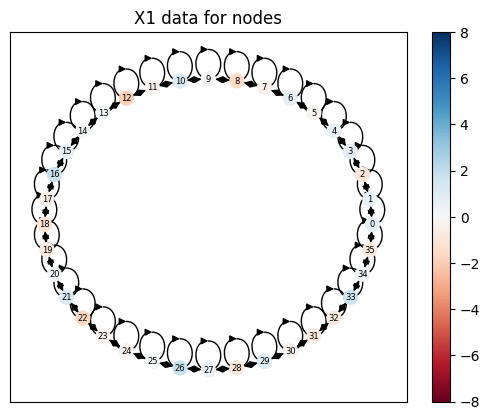

In [20]:
sample_graph = all_connected_3_datasets[0]['train']['inputs'][0][0]
draw_jraph_graph_structure(sample_graph)

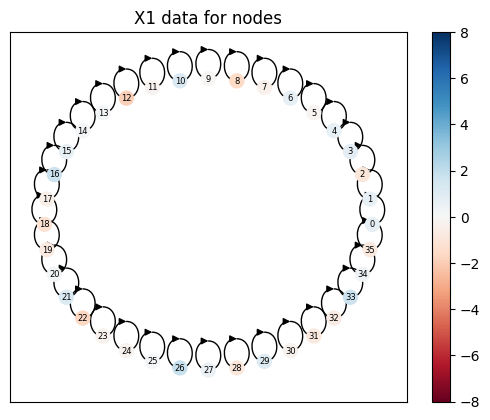

In [21]:
sample_graph = all_solo_datasets[0]['train']['inputs'][0][0]
draw_jraph_graph_structure(sample_graph)

In [22]:
def create_workdirs(trials):
    fully_connected_workdir_start = "tests/outputs/fully_connected"
    connected_7_workdir_start = "tests/outputs/connected_7"
    connected_5_workdir_start = "tests/outputs/connected_5"
    connected_3_workdir_start = "tests/outputs/connected_3"
    solo_workdir_start = "tests/outputs/solo"
    
    fully_connected_workdirs = []
    connected_7_workdirs = []
    connected_5_workdirs = []
    connected_3_workdirs = []
    solo_workdirs = []
    for i in range(trials):
        fully_connected_trial_workdir = os.path.join(fully_connected_workdir_start, f"trial-{i}")
        connected_7_trial_workdir = os.path.join(connected_7_workdir_start, f"trial-{i}")
        connected_5_trial_workdir = os.path.join(connected_5_workdir_start, f"trial-{i}")
        connected_3_trial_workdir = os.path.join(connected_3_workdir_start, f"trial-{i}")
        solo_trial_workdir = os.path.join(solo_workdir_start, f"trial-{i}")

        fully_connected_workdirs.append(fully_connected_trial_workdir)
        connected_7_workdirs.append(connected_7_trial_workdir)
        connected_5_workdirs.append(connected_5_trial_workdir)
        connected_3_workdirs.append(connected_3_trial_workdir)
        solo_workdirs.append(solo_trial_workdir)

    return fully_connected_workdirs, connected_7_workdirs, connected_5_workdirs, connected_3_workdirs, solo_workdirs

In [23]:
fully_connected_workdirs, connected_workdirs_7, connected_workdirs_5, connected_workdirs_3, solo_workdirs = create_workdirs(num_trials)

In [24]:
fully_connected_eval_metrics = []
connected_7_eval_metrics = []
connected_5_eval_metrics = []
connected_3_eval_metrics = []
solo_eval_metrics = []

all_fully_connected_epoch_losses = []
all_connected_7_epoch_losses = []
all_connected_5_epoch_losses = []
all_connected_3_epoch_losses = []
all_solo_epoch_losses = []

In [25]:
for trial in range(num_trials):
    _, _, fully_connected_eval_metric, fully_connected_epoch_losses = train_and_evaluate_with_data(
        config=fully_connected_configs[trial], workdir=fully_connected_workdirs[trial], datasets=all_fully_connected_datasets[trial])
    
    fully_connected_eval_metrics.append(fully_connected_eval_metric)
    
    all_fully_connected_epoch_losses.append(fully_connected_epoch_losses)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 50, 'eval_every_epochs': 1, 'fully_connected_edges': None, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 65, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size

KeyboardInterrupt: 

In [26]:
for trial in range(num_trials):
    _, _, connected_7_eval_metric, connected_7_epoch_losses = train_and_evaluate_with_data(
        config=connected_configs_7[trial], workdir=connected_workdirs_7[trial], datasets=all_connected_7_datasets[trial])
    
    connected_7_eval_metrics.append(connected_7_eval_metric)
    
    all_connected_7_epoch_losses.append(connected_7_epoch_losses)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 50, 'eval_every_epochs': 1, 'fully_connected_edges': 7, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 65, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | 

In [27]:
for trial in range(num_trials):
    _, _, connected_5_eval_metric, connected_5_epoch_losses = train_and_evaluate_with_data(
        config=connected_configs_5[trial], workdir=connected_workdirs_5[trial], datasets=all_connected_5_datasets[trial])
    
    connected_5_eval_metrics.append(connected_5_eval_metric)
    
    all_connected_5_epoch_losses.append(connected_5_epoch_losses)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 50, 'eval_every_epochs': 1, 'fully_connected_edges': 5, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 65, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | 

In [28]:
for trial in range(num_trials):
    _, _, connected_3_eval_metric, connected_3_epoch_losses = train_and_evaluate_with_data(
        config=connected_configs_3[trial], workdir=connected_workdirs_3[trial], datasets=all_connected_3_datasets[trial])
    
    connected_3_eval_metrics.append(connected_3_eval_metric)
    
    all_connected_3_epoch_losses.append(connected_3_epoch_losses)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 50, 'eval_every_epochs': 1, 'fully_connected_edges': 3, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 65, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | 

In [34]:
for trial in range(num_trials):
    _, _, solo_eval_metric, solo_epoch_losses = train_and_evaluate_with_data(
        config=solo_configs[trial], workdir=solo_workdirs[trial], datasets=all_solo_datasets[trial])
    
    solo_eval_metrics.append(solo_eval_metric)
    
    all_solo_epoch_losses.append(solo_epoch_losses)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 50, 'eval_every_epochs': 1, 'fully_connected_edges': 1, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 65, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | 

here we will take the average of the last 10 of 50 epochs.

In [35]:
def average_last_epochs(average_after, epoch_losses):
    filtered_losses = epoch_losses[average_after:]
    avg_loss = np.mean(filtered_losses)
    return avg_loss

In [36]:
avg_connected_7_losses = []
avg_connected_5_losses = []
avg_connected_3_losses = []
avg_solo_losses = []
average_after_epoch = solo_configs[0].epochs - 10 # we want 10 epochs total, so we subtract to get where we should start averaging
for trial in range(num_trials):
    avg_connected_7_loss = average_last_epochs(average_after_epoch, all_connected_7_epoch_losses[trial])

    avg_connected_5_loss = average_last_epochs(average_after_epoch, all_connected_5_epoch_losses[trial])

    avg_connected_3_loss = average_last_epochs(average_after_epoch, all_connected_3_epoch_losses[trial])

    avg_solo_loss = average_last_epochs(average_after_epoch, all_solo_epoch_losses[trial])

    avg_connected_7_losses.append(avg_connected_7_loss)
    avg_connected_5_losses.append(avg_connected_5_loss)
    avg_connected_3_losses.append(avg_connected_3_loss)
    avg_solo_losses.append(avg_solo_loss)

In [37]:
print(avg_connected_7_losses)
print(avg_connected_5_losses)
print(avg_connected_3_losses)
print(avg_solo_losses)

[0.99604464, 0.9403306, 0.9665345, 0.9865715, 1.014522, 0.9791037, 0.9791037, 1.0978878, 0.9785441, 0.9245108]
[0.7911881, 0.72747505, 0.7517646, 0.7260231, 0.76149464, 0.76684225, 0.76684225, 0.8784798, 0.7419151, 0.7656745]
[0.966211, 0.9433092, 0.9481964, 0.9533764, 0.95980394, 0.9781823, 0.9781823, 1.0453671, 0.92346877, 0.95126724]
[1.3033626, 1.3069439, 1.2640886, 1.2887369, 1.3235165, 1.3083115, 1.3083115, 1.4113057, 1.244005, 1.2961566]


## Performing Tests

We have gathered the data for the statistical tests. First, we check that the variances are roughly equal:

In [38]:
from scipy import stats

print(np.var(avg_connected_7_losses), np.var(avg_connected_5_losses), np.var(avg_connected_5_losses), np.var(avg_solo_losses))
# variances are very similar

0.001982883 0.0017141693 0.0017141693 0.0017406729


Now we will perform a paired T test for each connection type:

In [39]:
print("7 Connected vs Solo")
stats.ttest_ind(a=avg_connected_7_losses, b=avg_solo_losses, equal_var=True)

7 Connected vs Solo


Ttest_indResult(statistic=-15.690934230506027, pvalue=6.053399797811973e-12)

In [40]:
print("5 Connected vs Solo")
stats.ttest_ind(a=avg_connected_5_losses, b=avg_solo_losses, equal_var=True)

5 Connected vs Solo


Ttest_indResult(statistic=-27.444189572173148, pvalue=3.854062011214843e-16)

In [41]:
print("3 Connected vs Solo")
stats.ttest_ind(a=avg_connected_3_losses, b=avg_solo_losses, equal_var=True)

3 Connected vs Solo


Ttest_indResult(statistic=-19.657089782547484, pvalue=1.2980651650320703e-13)

In [42]:
print("5 Connected vs 7 Connected")
stats.ttest_ind(a=avg_connected_5_losses, b=avg_connected_7_losses, equal_var=True)

5 Connected vs 7 Connected


Ttest_indResult(statistic=-10.782890544078706, pvalue=2.7659574133930217e-09)

In [43]:
print("5 Connected vs 3 Connected")
stats.ttest_ind(a=avg_connected_5_losses, b=avg_connected_3_losses, equal_var=True)

5 Connected vs 3 Connected


Ttest_indResult(statistic=-11.419063254629135, pvalue=1.1170702372935128e-09)

In [44]:
print("7 Connected vs 3 Connected")
stats.ttest_ind(a=avg_connected_7_losses, b=avg_connected_3_losses, equal_var=True)

7 Connected vs 3 Connected


Ttest_indResult(statistic=1.192619219961142, pvalue=0.24850359233022384)

## Plotting Predictions & Metrics

Let's visualize our results more clearly:

In [ ]:
from utils.jraph_vis import plot_predictions

INFO:root:Initializing network.


Checkpoint directory: tests/outputs/connected_7/trial-0/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 834
INFO:absl:Checkpoi

Checkpoint directory: tests/outputs/connected_5/trial-0/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 834
INFO:absl:Checkpoi

Checkpoint directory: tests/outputs/connected_3/trial-0/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 834
INFO:absl:Checkpoi

Checkpoint directory: tests/outputs/solo/trial-0/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 834
INFO:absl:Checkpoi

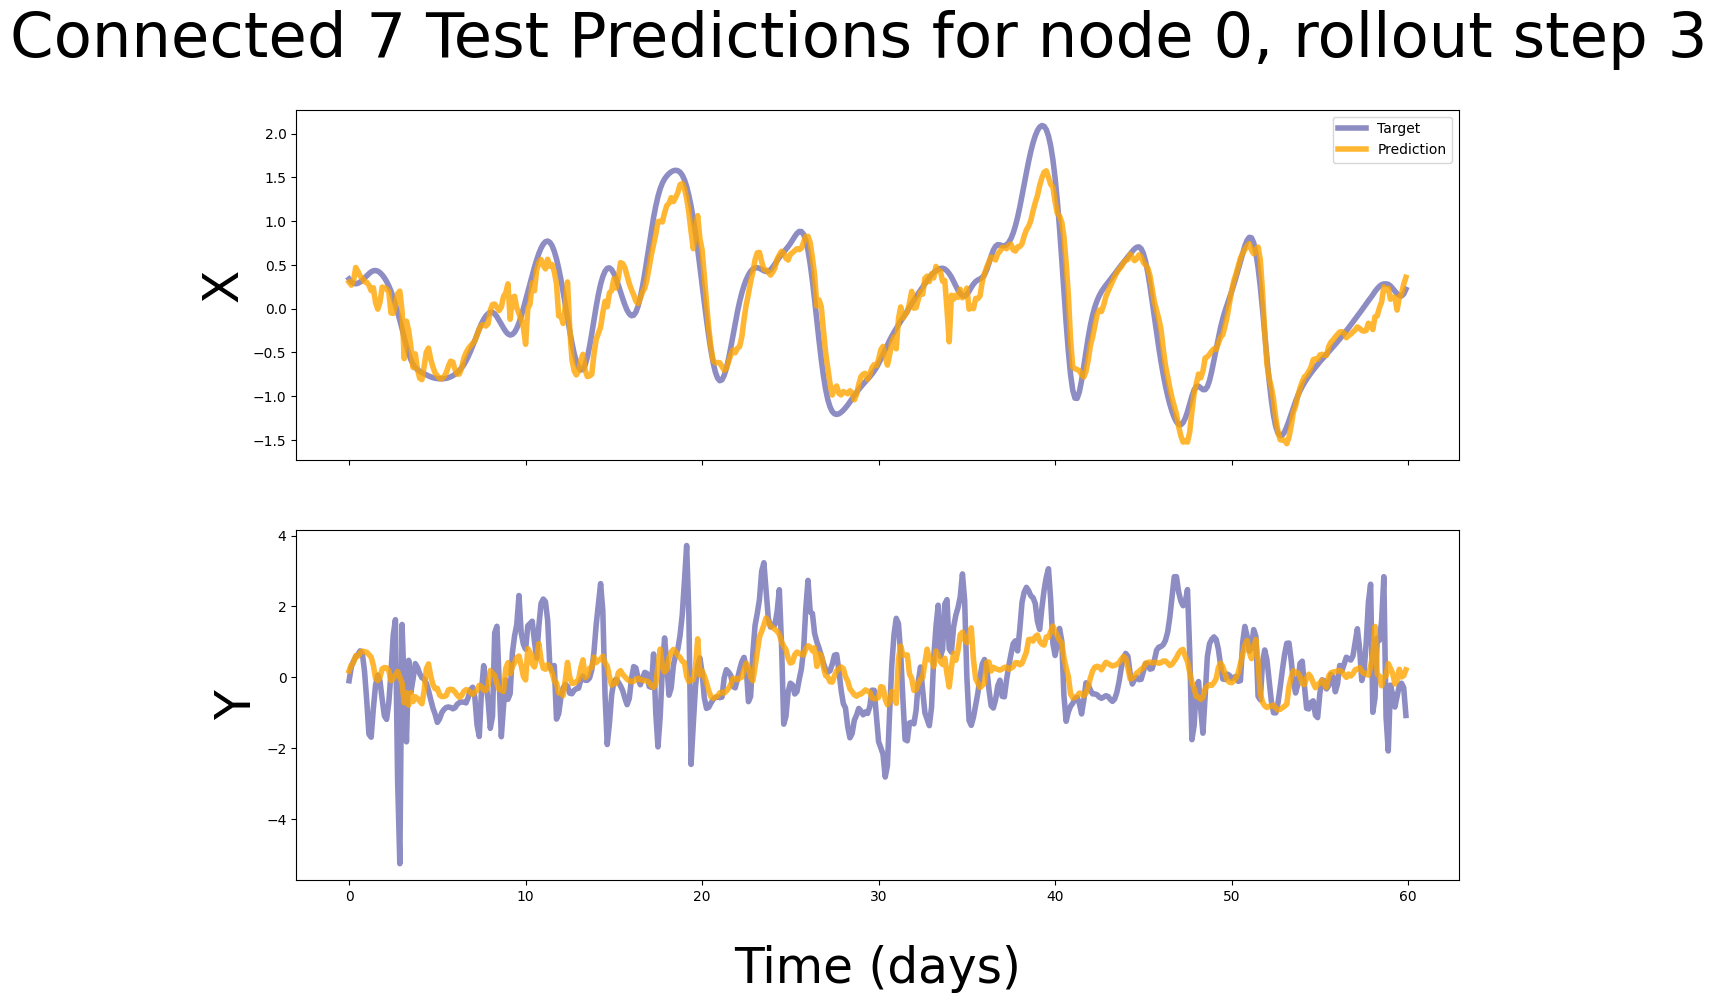

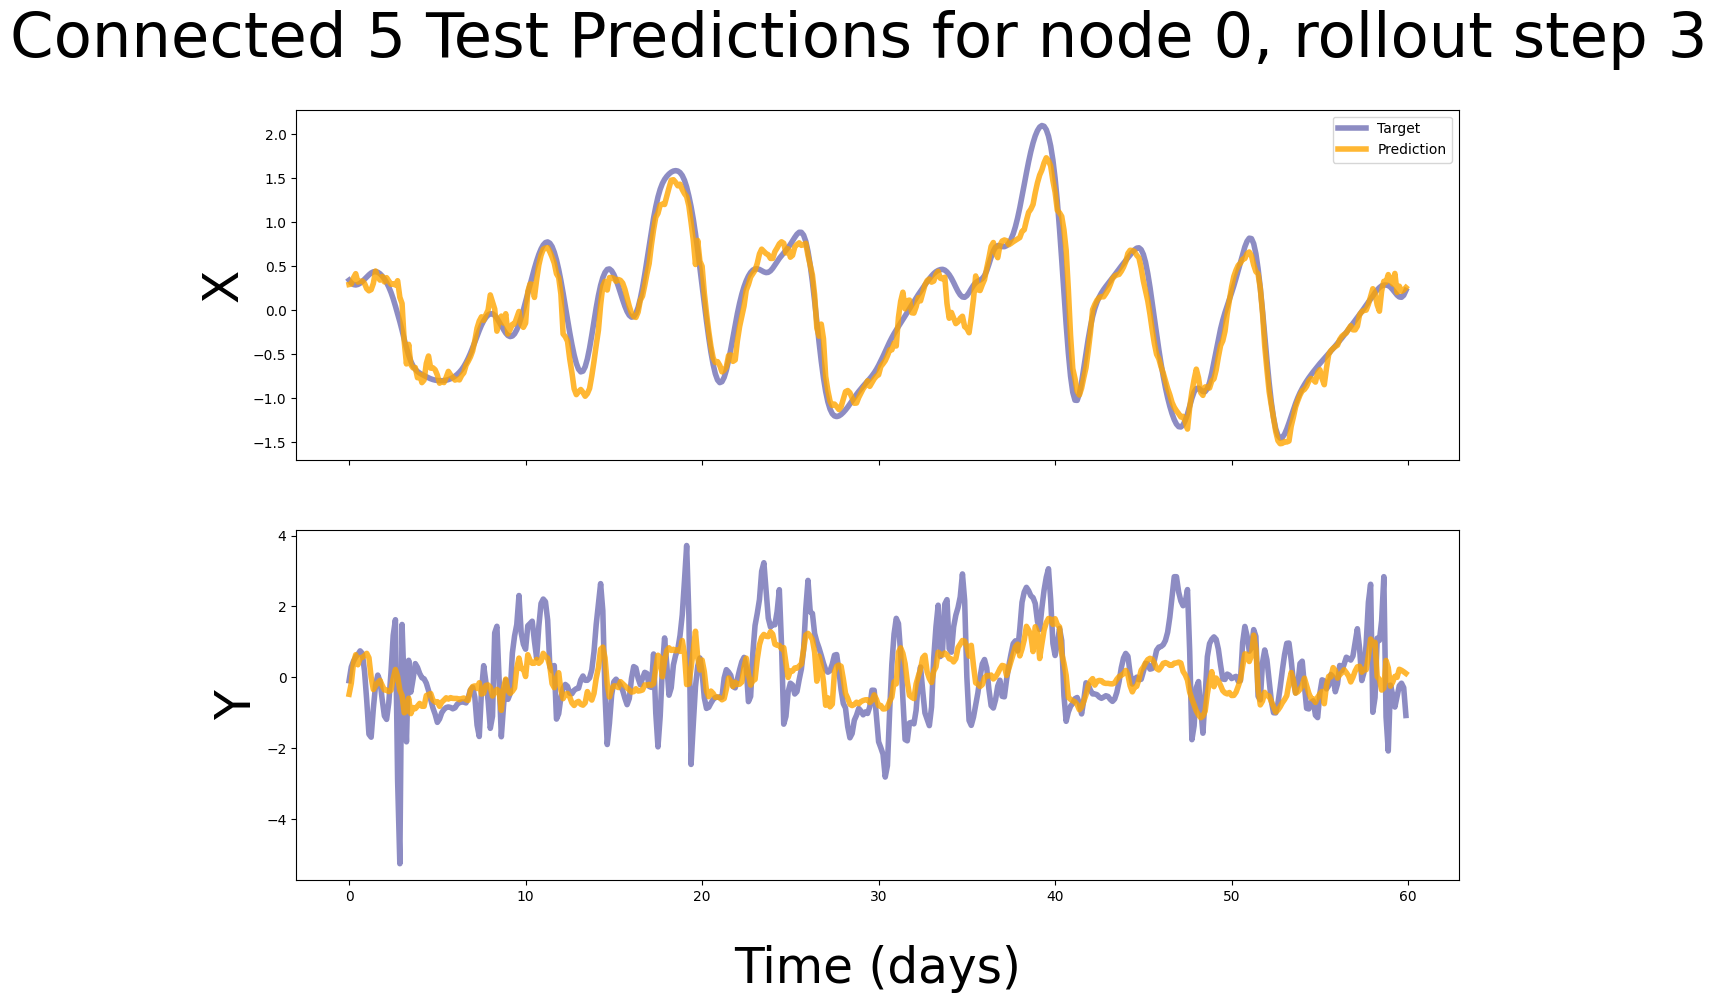

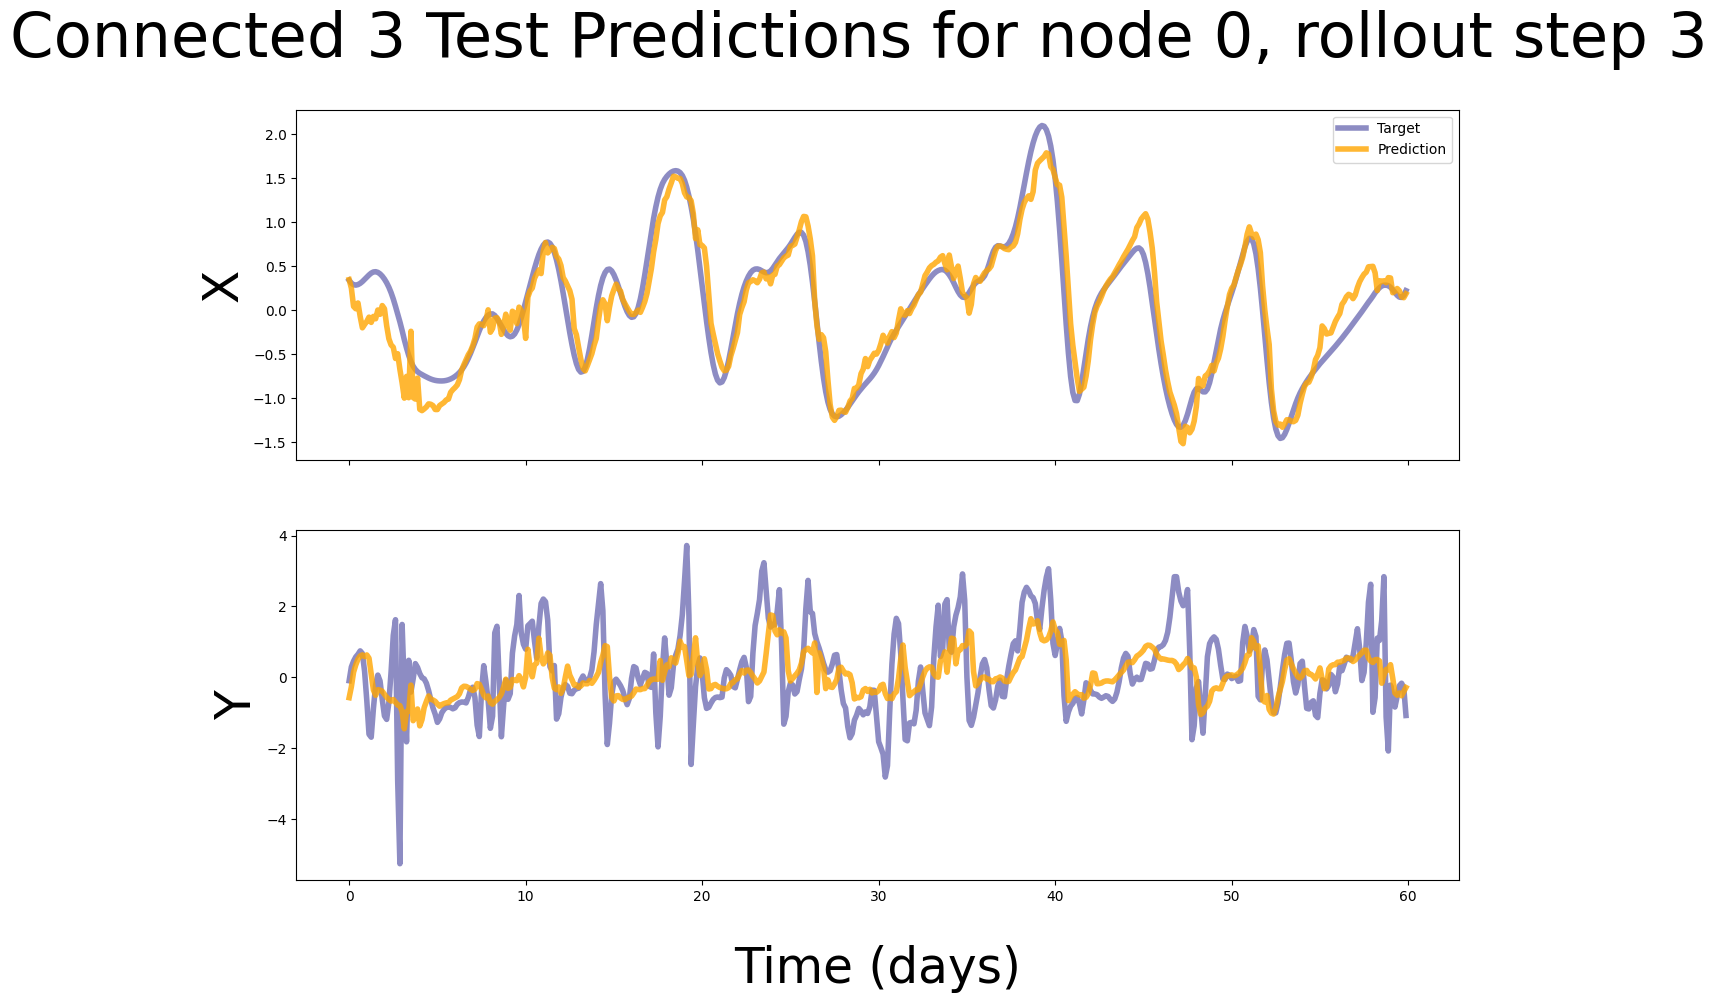

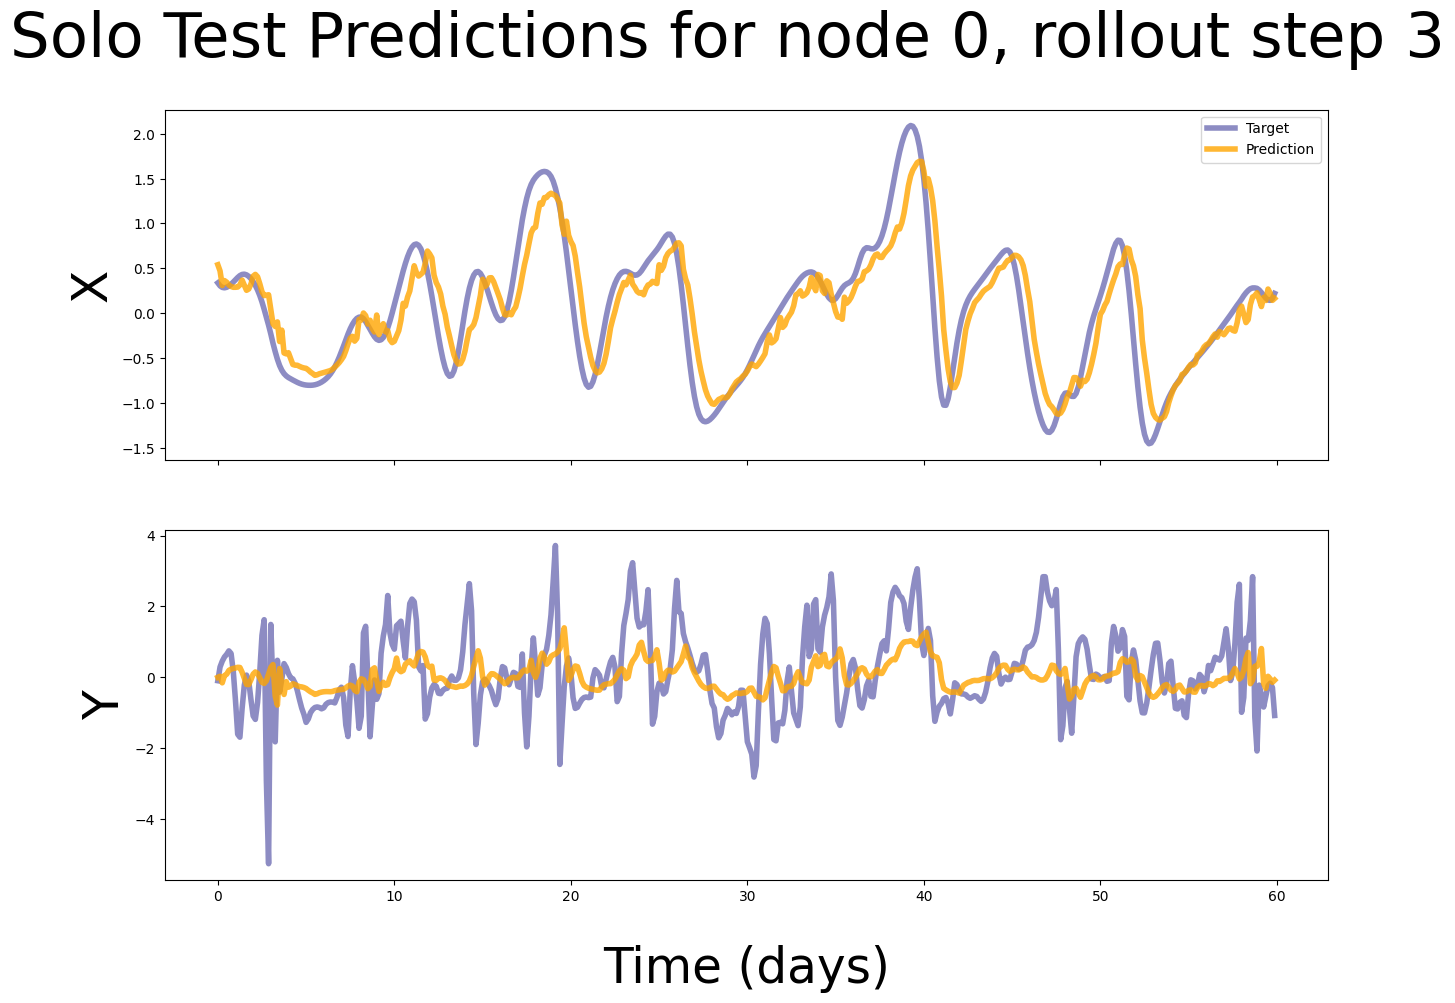

In [46]:
plot_predictions(
    config=connected_configs_7[0],
    workdir=connected_workdirs_7[0], # for loading checkpoints 
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    datasets=all_connected_7_datasets[0],
    node=0, # 0-indexed 
    plot_mode="test", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Connected 7 Test Predictions for node 0, rollout step 3"
)

plot_predictions(
    config=connected_configs_5[0],
    workdir=connected_workdirs_5[0], # for loading checkpoints 
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    datasets=all_connected_5_datasets[0],
    node=0, # 0-indexed 
    plot_mode="test", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Connected 5 Test Predictions for node 0, rollout step 3"
)

plot_predictions(
    config=connected_configs_3[0],
    workdir=connected_workdirs_3[0], # for loading checkpoints 
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    datasets=all_connected_3_datasets[0],
    node=0, # 0-indexed 
    plot_mode="test", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Connected 3 Test Predictions for node 0, rollout step 3"
)

plot_predictions(
    config=solo_configs[0],
    workdir=solo_workdirs[0], # for loading checkpoints 
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    datasets=all_solo_datasets[0],
    node=0, # 0-indexed 
    plot_mode="test", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Solo Test Predictions for node 0, rollout step 3"
)

In [59]:
def plot_loss_over_epoch(all_epoch_losses, num_epochs=None):
    if num_epochs is not None:
        epoch_losses = [epoch_losses[:num_epochs] for epoch_losses in all_epoch_losses]
    else:
        epoch_losses = all_epoch_losses
        # arbitrarily choses
        num_epochs = len(all_epoch_losses[0])
        
    epochs = jnp.arange(num_epochs)
    connection_types = ["7-connected edges", "5-connected edges", "3-connected edges", "solo edges"]
    colors = ["red", "blue", "green", "purple"]
    for i in range(len(epoch_losses)):
        plt.plot(epochs, epoch_losses[i], alpha=0.6, label=connection_types[i], c=colors[i], marker='o')
    plt.ylabel("Epoch Val Loss (log scale)")
    plt.xlabel("Epoch Number")
    plt.title("Epoch Val Losses for 7-, 5-, 3- and Not-Connected Edges")
    plt.legend(fontsize='medium')
    plt.show()

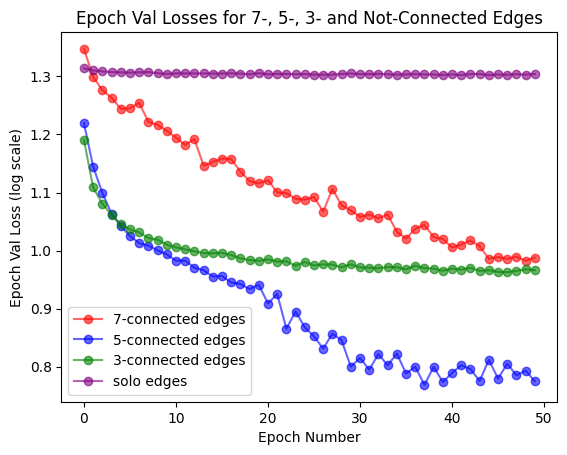

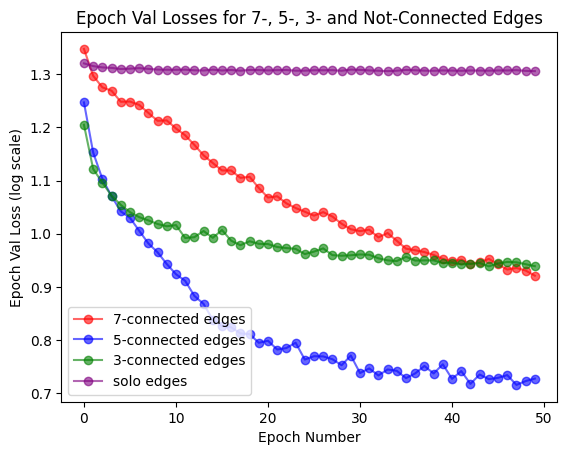

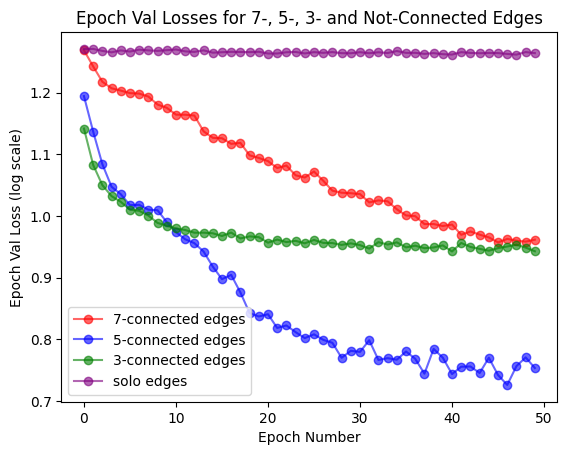

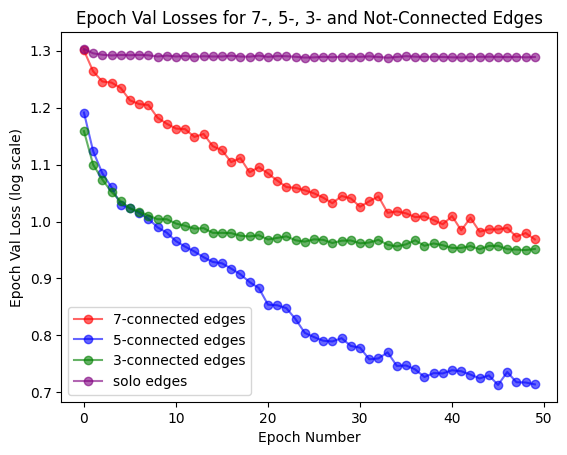

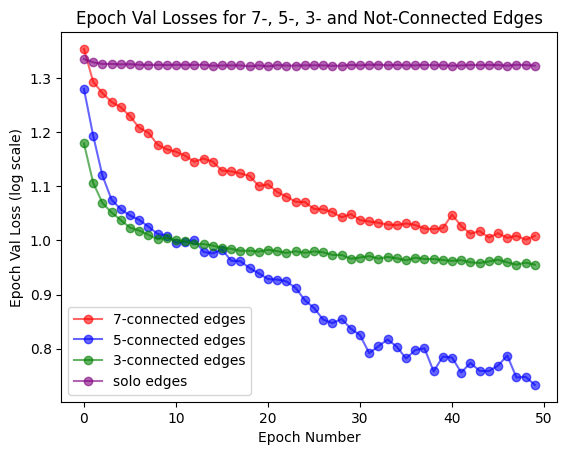

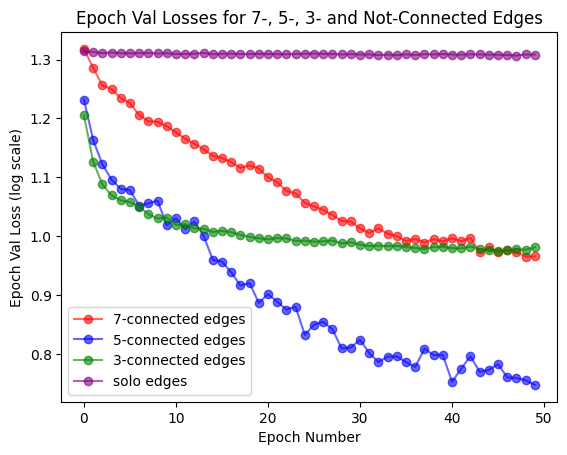

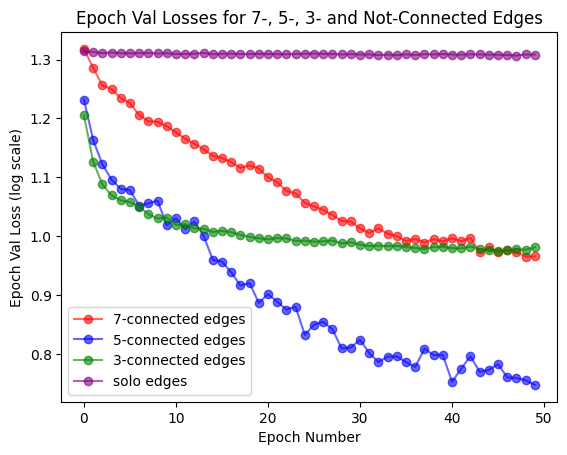

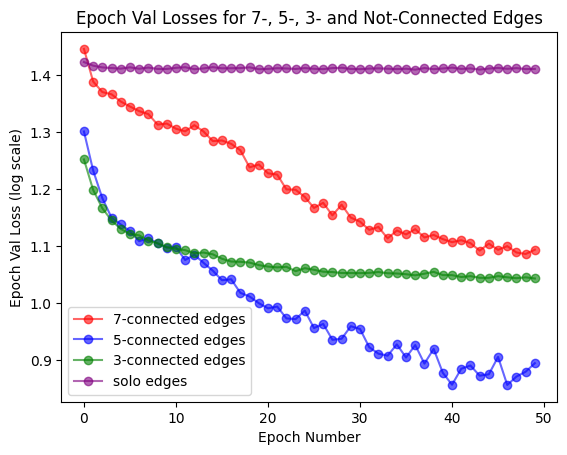

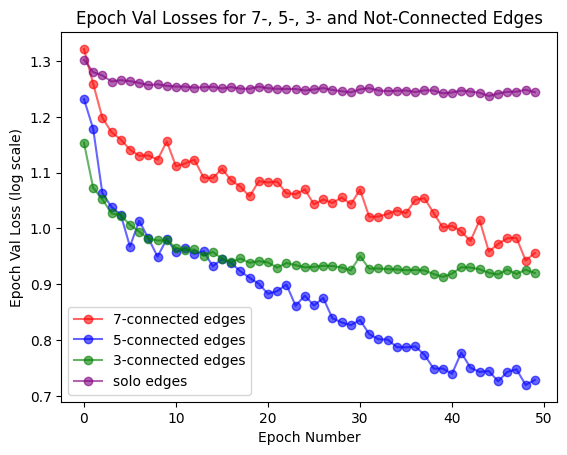

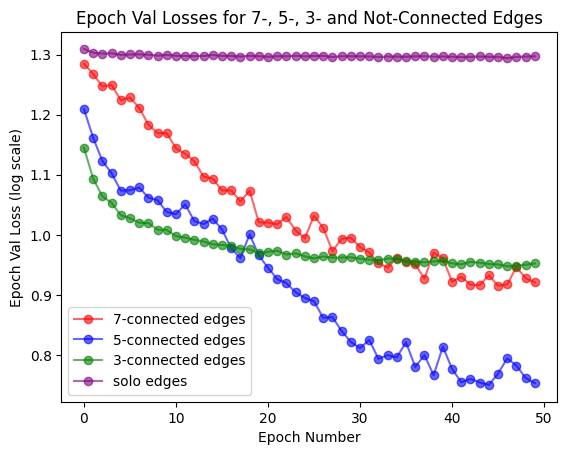

In [60]:
for i in range(num_trials):
    all_epoch_losses = [all_connected_7_epoch_losses[i], all_connected_5_epoch_losses[i], all_connected_3_epoch_losses[i], all_solo_epoch_losses[i]]
    plot_loss_over_epoch(all_epoch_losses)

In [61]:
import os
from typing import Dict, Iterable, List, Optional, Callable
from utils.jraph_training import MSE, MB, ME, RMSE, CRMSE, FB, FE, R, R2, D

In [62]:
def rollout_metric_list(
        metric_funcs: Iterable[Callable],
        state: train_state.TrainState, 
        input_window_graphs: Iterable[jraph.GraphsTuple],
        target_window_graphs: Iterable[jraph.GraphsTuple],
        n_rollout_steps: int,
        rngs: Optional[Dict[str, jnp.ndarray]] = None,
    ) -> Dict[str, List[float]]:
    """ Computes a suite of metrics for an n-step rollout. 
    
        Also returns predicted nodes.
    """
    assert n_rollout_steps > 0
    assert len(target_window_graphs) == n_rollout_steps, (len(target_window_graphs), n_rollout_steps)

    curr_input_window_graphs = input_window_graphs
    pred_nodes = []

    # initialize metrics dict 
    metric_totals = {metric.__name__.lower(): [] for metric in metric_funcs}

    for i in range(n_rollout_steps):
        pred_graphs_list = state.apply_fn(state.params, curr_input_window_graphs, rngs=rngs) 
        pred_graph = pred_graphs_list[0]

        # retrieve the new input window 
        curr_input_window_graphs = curr_input_window_graphs[1:] + [pred_graph]

        preds = pred_graph.nodes

        targets = target_window_graphs[i].nodes

        # compute metrics
        for metric in metric_funcs:
            metric_val = metric(targets=targets, preds=preds)
            metric_totals[metric.__name__.lower()].append(metric_val) # adds 
    
        pred_nodes.append(preds)

    return metric_totals

In [63]:
def evaluate_model_rollout(
    state: train_state.TrainState,
    n_rollout_steps: int,
    datasets: Dict[str, Dict[str, Iterable[jraph.GraphsTuple]]], 
    # first key = train/test/val, second key = input/target 
    split: str # e.g. ["val", "test"],
) -> Dict[str, List[float]]:
    """Evaluates the model on metrics over the specified splits (i.e. modes)."""

    # Loop over each split independently.
    eval_metrics_dict = {}
    input_data = datasets[split]['inputs']
    target_data = datasets[split]['targets']

    # Initialize metrics dict
    metric_totals = {metric_name: [[] for _ in range(n_rollout_steps)] for metric_name in 
                     ["mse", "mb", "me", "rmse", "crmse", "fb", "fe", "r", "r2", "d"]}

    # Loop over individual windows in the dataset 
    for (input_window_graphs, target_window_graphs) in zip(input_data, target_data):
        split_metrics_update = rollout_metric_list(
            metric_funcs=[MSE, MB, ME, RMSE, CRMSE, FB, FE, R, R2, D],
            state=state, 
            n_rollout_steps=n_rollout_steps, 
            input_window_graphs=input_window_graphs, 
            target_window_graphs=target_window_graphs)

        # Update metrics.
        for metric_name, step_values in split_metrics_update.items():
            for step, values in enumerate(step_values):
                metric_totals[metric_name][step].append(values)

    # Compute averages for each step in the rollout 
    eval_metrics_dict = {metric_name: np.array([np.mean(step_values) for step_values in step_values_list])
                         for metric_name, step_values_list in metric_totals.items()}

    return eval_metrics_dict  # pytype: disable=bad-return-type

In [89]:
def plot_multirollout_metrics_multiple_configs(
    configs,
    workdirs, # for loading checkpoints 
    plot_mode, # i.e. "train"/"val"/"test"
    all_datasets=None,
    all_metrics_dicts=None,
    title=''):

    assert plot_mode in ["train", "val", "test"]
    # set up plot
    # NOTE: remember to update the axes if you include more/less metrics
    fig, axes  = plt.subplots(10, figsize=(20, 35))
    if title == '':
        fig.suptitle(f"{plot_mode} rollout metrics, averaged across {configs[0].K} nodes", size=28)
    else:
        fig.suptitle(title, size=24)
    colors = ['blue', 'red', 'green', 'purple']
    labels = ['7-connected', "5-connected", "3-connected", "solo"]
    current_plot = None

    tot_metrics_dict = []
    
    for index in range(len(configs)):
        config = configs[index]
        workdir = workdirs[index]

        checkpoint_dir = os.path.join(workdir, 'checkpoints')
        assert os.path.exists(checkpoint_dir)

        # Get datasets, organized by split.
        if all_datasets is None:
            logging.info('Generating datasets from config because none provided.')
            datasets = create_dataset(config)
        else:
            datasets = all_datasets[index]

        plot_set = datasets[plot_mode]
        input_data = plot_set['inputs']
        n_rollout_steps = config.output_steps
        rollout_nums = np.arange(n_rollout_steps)

        # Create the evaluation state, corresponding to a deterministic model.
        logging.info('Initializing network.')
        rng = jax.random.key(0)
        rng, init_rng = jax.random.split(rng)
        sample_input_window = input_data[0]
        eval_net = create_model(config, deterministic=True)
        params = jax.jit(eval_net.init)(init_rng, sample_input_window)
        parameter_overview.log_parameter_overview(params) # logs to logging.info

        # Create the optimizer and state.
        # (we don't actually need the optimizer for evaluation, we just need it to create the state)
        tx = create_optimizer(config)
        state = train_state.TrainState.create(
            apply_fn=eval_net.apply, params=params, tx=tx
        )

        # load the checkpoint state
        ckpt = checkpoint.Checkpoint(checkpoint_dir)
        state = ckpt.restore(state) # restore latest checkpoint 

        # gets all metrics
        if all_metrics_dicts is None: 
            logging.info('Generating metrics from dataset because none provided.')
            metrics_dict = evaluate_model_rollout(
                state=state,
                n_rollout_steps=config.output_steps,
                datasets=datasets,
                split=plot_mode)
        else:
            metrics_dict = all_metrics_dicts[index]

        tot_metrics_dict.append(metrics_dict)
        
        plot_num = 0
        for key in metrics_dict:
            current_plot = axes[plot_num]
            current_plot.set_title(f"{key}", size=20)
            plt.xlabel('Rollout Number', size=16)
            # plot rollout targets
            current_plot.plot(
                rollout_nums,
                metrics_dict[key],
                alpha=0.8,
                linestyle='dashed',
                marker='o',
                c=colors[index],
                label=labels[index])
            
            plot_num += 1
    fig.legend(labels, loc='upper right', ncol=len(labels))
    fig.tight_layout()
    return tot_metrics_dict

INFO:root:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+------

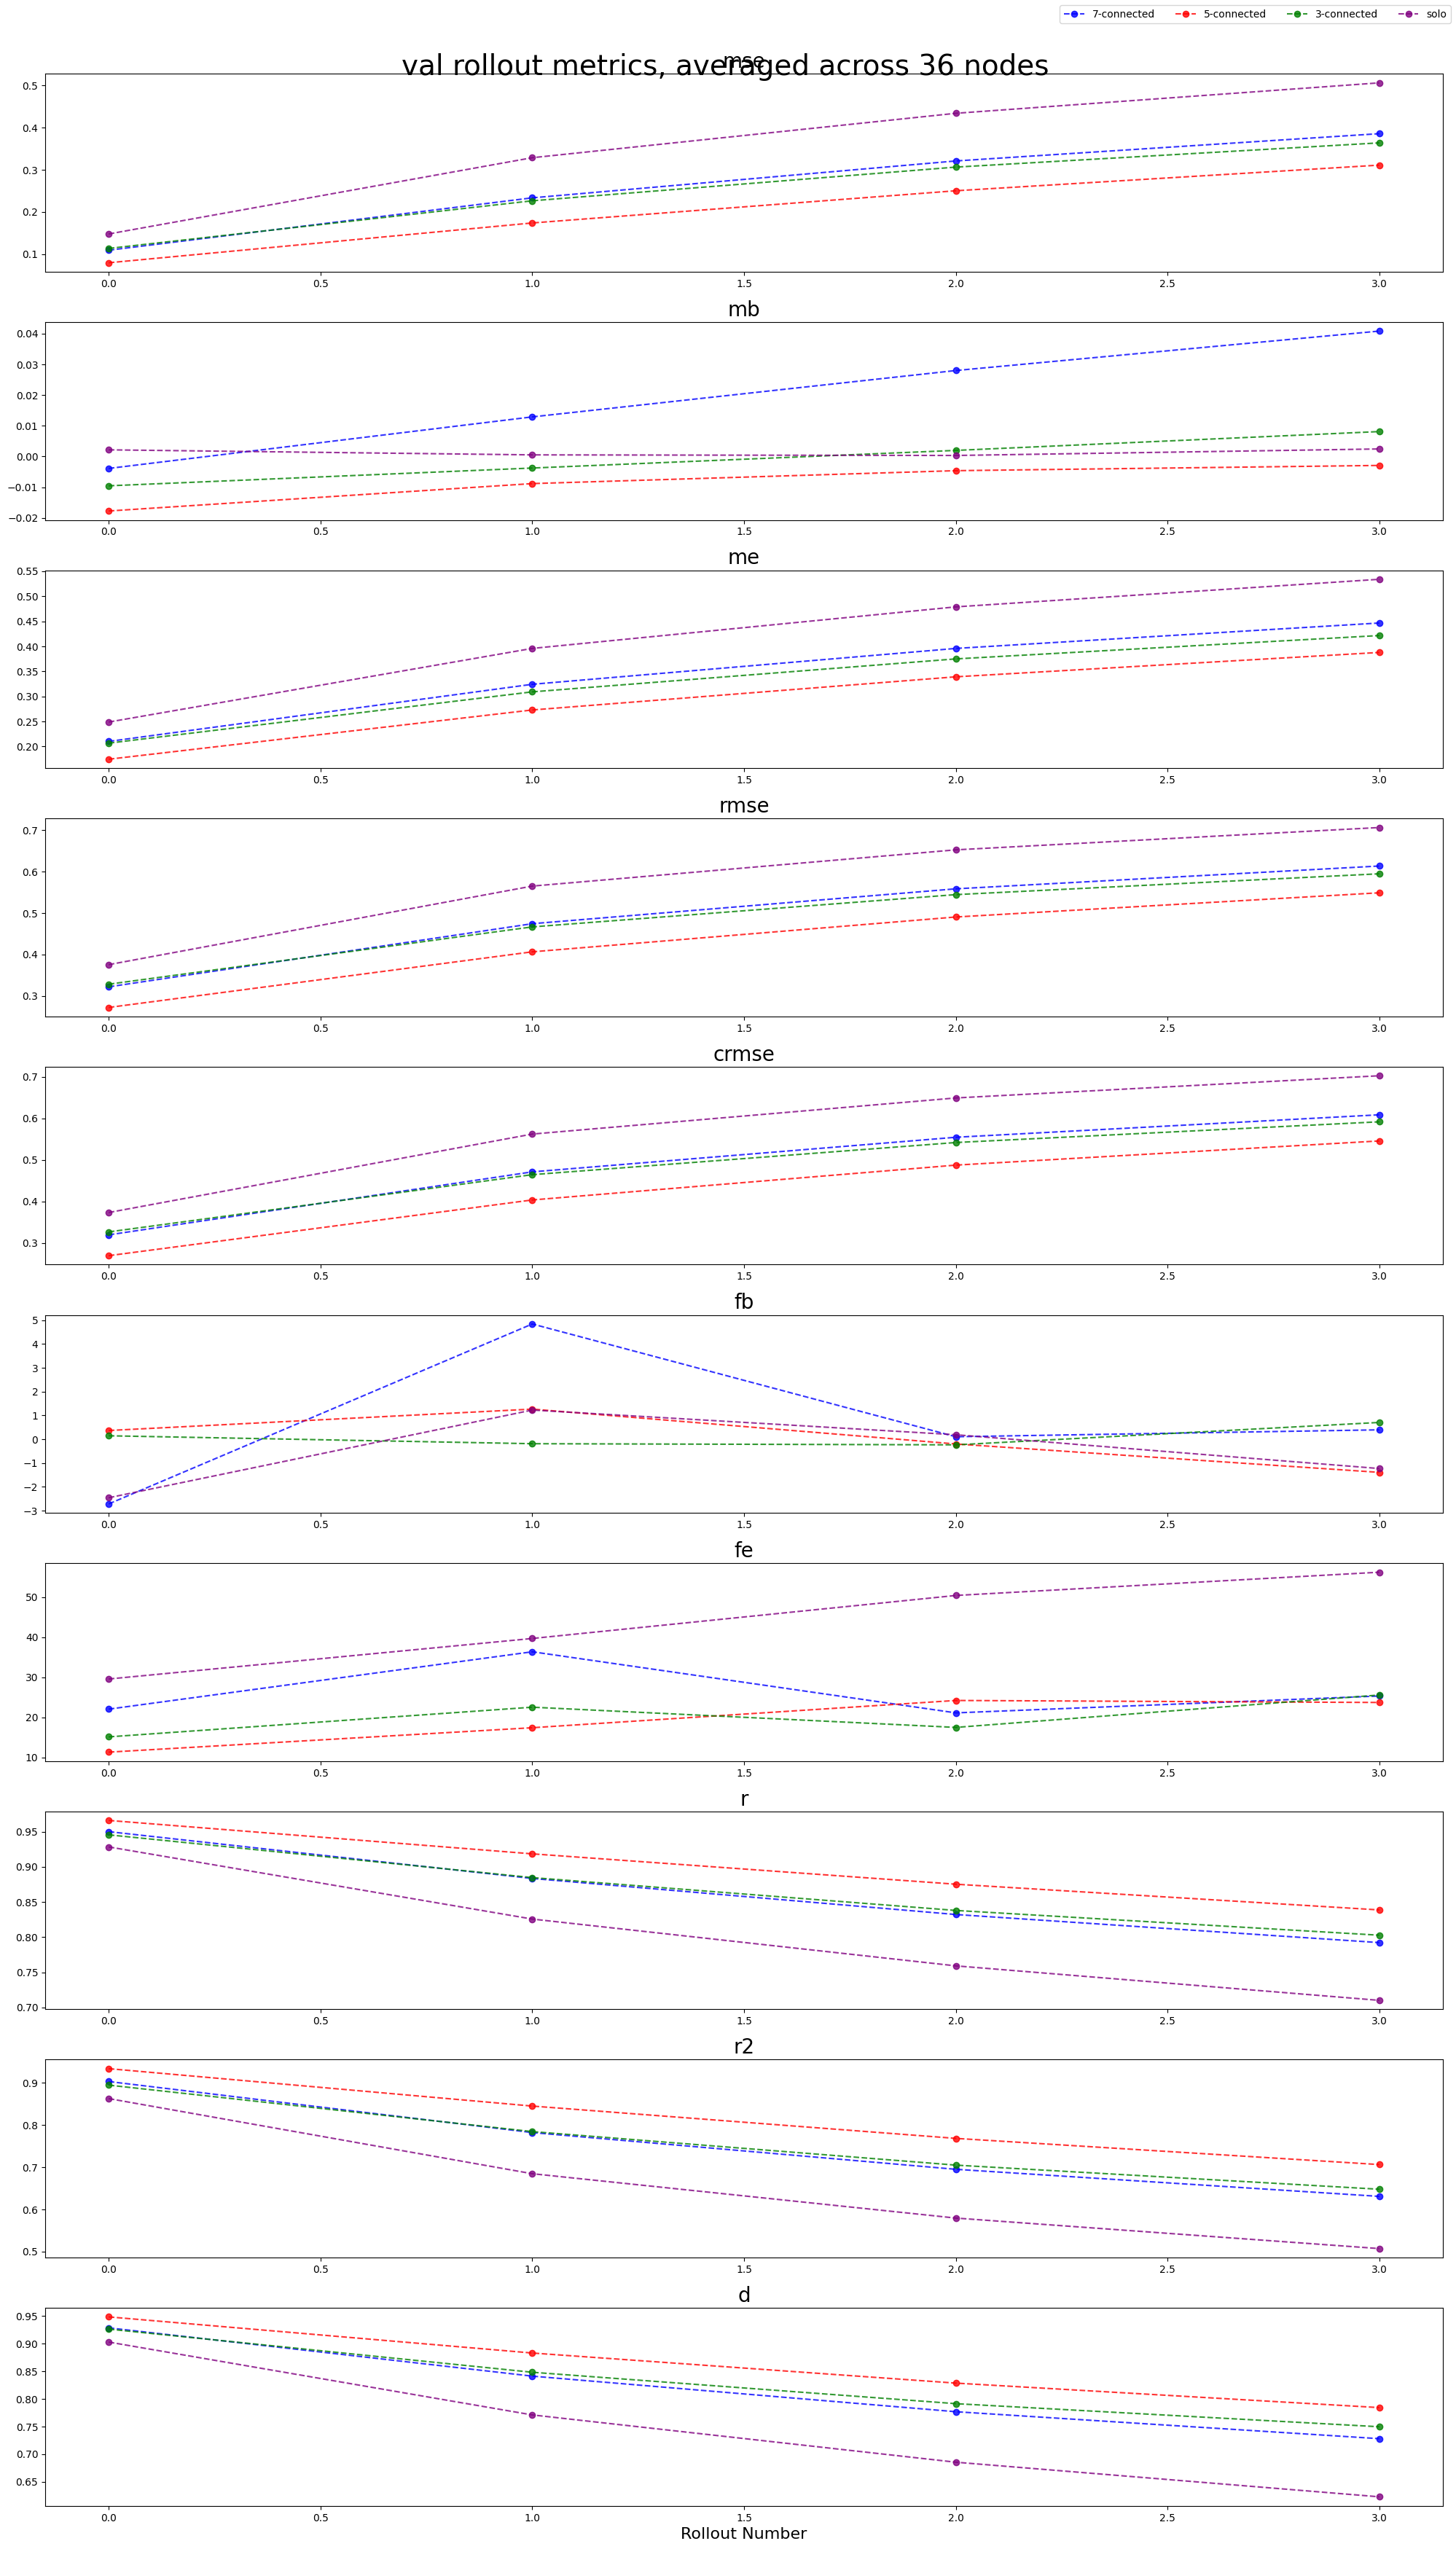

In [90]:
configs = [connected_configs_7[0], connected_configs_5[0],  connected_configs_3[0], solo_configs[0]]
workdirs = [connected_workdirs_7[0], connected_workdirs_5[0], connected_workdirs_3[0], solo_workdirs[0]]
multi_datasets = [all_connected_7_datasets[0], all_connected_5_datasets[0], all_connected_3_datasets[0], all_solo_datasets[0]] 

metrics_dict = plot_multirollout_metrics_multiple_configs(
    configs=configs,
    workdirs=workdirs,
    plot_mode='val',
    all_datasets=multi_datasets)

In [99]:
for key in metrics_dict[0]:
    print("5-Connected vs 7-Connected", key)
    print(stats.ttest_ind(a=metrics_dict[1][key], b=metrics_dict[0][key], equal_var=True))
    print()

5-Connected vs 7-Connected mse
Ttest_indResult(statistic=-0.752468059064746, pvalue=0.48023857730930486)

5-Connected vs 7-Connected mb
Ttest_indResult(statistic=-2.7421302249214605, pvalue=0.03364059598565749)

5-Connected vs 7-Connected me
Ttest_indResult(statistic=-0.7333630710272726, pvalue=0.4909861208968843)

5-Connected vs 7-Connected rmse
Ttest_indResult(statistic=-0.7156448945457108, pvalue=0.5010987120975721)

5-Connected vs 7-Connected crmse
Ttest_indResult(statistic=-0.7125080731642293, pvalue=0.5029035301475213)

5-Connected vs 7-Connected fb
Ttest_indResult(statistic=-0.38947480240315224, pvalue=0.7103734123744212)

5-Connected vs 7-Connected fe
Ttest_indResult(statistic=-1.5210448539339474, pvalue=0.1790664270855732)

5-Connected vs 7-Connected r
Ttest_indResult(statistic=0.8024923371937648, pvalue=0.4528737172287246)

5-Connected vs 7-Connected r2
Ttest_indResult(statistic=0.7887383353580331, pvalue=0.460285074314127)

5-Connected vs 7-Connected d
Ttest_indResult(statis

In [100]:
for key in metrics_dict[0]:
    print("5-Connected vs 3-Connected", key)
    print(stats.ttest_ind(a=metrics_dict[1][key], b=metrics_dict[2][key], equal_var=True))
    print()

5-Connected vs 3-Connected mse
Ttest_indResult(statistic=-0.6623112014547463, pvalue=0.5323718271070683)

5-Connected vs 3-Connected mb
Ttest_indResult(statistic=-1.533810123676629, pvalue=0.17597130622882365)

5-Connected vs 3-Connected me
Ttest_indResult(statistic=-0.5253938535479294, pvalue=0.6181509412158552)

5-Connected vs 3-Connected rmse
Ttest_indResult(statistic=-0.6468008554319101, pvalue=0.5416980154406409)

5-Connected vs 3-Connected crmse
Ttest_indResult(statistic=-0.6565797556092372, pvalue=0.5358060630883947)

5-Connected vs 3-Connected fb
Ttest_indResult(statistic=-0.16109142715688585, pvalue=0.8773086625685902)

5-Connected vs 3-Connected fe
Ttest_indResult(statistic=-0.2643762666674517, pvalue=0.8003368282264949)

5-Connected vs 3-Connected r
Ttest_indResult(statistic=0.7713574390138045, pvalue=0.4697730134116873)

5-Connected vs 3-Connected r2
Ttest_indResult(statistic=0.7625295991134475, pvalue=0.4746440895821912)

5-Connected vs 3-Connected d
Ttest_indResult(statis

In [101]:
for key in metrics_dict[0]:
    print("5-Connected vs Solo", key)
    print(stats.ttest_ind(a=metrics_dict[1][key], b=metrics_dict[3][key], equal_var=True))
    print()

5-Connected vs Solo mse
Ttest_indResult(statistic=-1.6263647898560867, pvalue=0.15499681237682922)

5-Connected vs Solo mb
Ttest_indResult(statistic=-2.944830939416905, pvalue=0.025785377047500554)

5-Connected vs Solo me
Ttest_indResult(statistic=-1.5616866459143528, pvalue=0.16938647755147063)

5-Connected vs Solo rmse
Ttest_indResult(statistic=-1.5437282520511175, pvalue=0.17360132119583124)

5-Connected vs Solo crmse
Ttest_indResult(statistic=-1.5485021949865032, pvalue=0.17247131620988362)

5-Connected vs Solo fb
Ttest_indResult(statistic=0.5912949794834774, pvalue=0.5759059187347237)

5-Connected vs Solo fe
Ttest_indResult(statistic=-3.7397538654220708, pvalue=0.009625268512962573)

5-Connected vs Solo r
Ttest_indResult(statistic=1.7172522249727582, pvalue=0.13674254737809524)

5-Connected vs Solo r2
Ttest_indResult(statistic=1.6920621065831658, pvalue=0.14158246377389652)

5-Connected vs Solo d
Ttest_indResult(statistic=1.645930370507349, pvalue=0.15087898821926715)

